In [1]:
import numpy as np, pandas as pd, scipy.sparse as sp, pathlib, time
from hyperheatpkg import hyperbolic_p_arr

ROOT = pathlib.Path().resolve().parents[0]
INTER = ROOT / "intermediate"
EDGE_TSV = INTER / "edges.tsv"
AFF_PARQUET = INTER / "affinity.parquet"

T = 0.5     # diffusion time
DIM_N = 3     # 3-dim hyperbolic space

print("Edge file size:", round(EDGE_TSV.stat().st_size/1e6,1), "MB")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/hrec/libs/hyperheatkernel/hyperheatpkg/julia`
  Activating project at `~/.julia/environments/v1.11`


Edge file size: 1005.2 MB


In [2]:
# convert weight to distance (rho)
t0 = time.time()


edges = pd.read_csv(EDGE_TSV, sep="\t", header=None,
                    names=["i","j","w"],
                    dtype={"i": str, "j": str, "w": float})

print(f"Loaded {len(edges):,} edges  in {time.time()-t0:.1f}s")

# edges["w"] = edges["w"].astype(str).str.strip()     # remove spaces
# edges["w"] = pd.to_numeric(edges["w"], errors="coerce")

def weight_to_rho(w):
    return 0.2 if w == 1.0 else 1.0 / w

edges["rho"] = edges["w"].apply(weight_to_rho)

Loaded 41,862,368 edges  in 7.0s


In [3]:
print(edges["w"].head(10))
print("NaNs in w :", edges["w"].isna().sum())
print("rho  min :", edges['rho'].min())
print("rho  max :", edges['rho'].max())
print("rho == 0 :", (edges['rho'] == 0).sum())

dtype : float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    2.0
6    1.0
7    1.0
8    2.0
9    1.0
Name: w, dtype: float64
NaNs in w : 0
rho  min : 0.00011142061281337047
rho  max : 0.5
rho == 0 : 0


In [4]:
rho_arr = edges["rho"].to_numpy(np.float64)
k_arr = hyperbolic_p_arr([rho_arr, T, DIM_N])
edges["k"] = k_arr.astype(np.float32)

# ensure no NaN values
print("NaN count:", np.isnan(edges['k']).sum())   # should be 0

AFF_PARQUET.parent.mkdir(exist_ok=True)
edges[["i", "j", "k"]].to_parquet(AFF_PARQUET, compression="zstd")
print("Affinity parquet saved:", AFF_PARQUET)

NaN count: 0
Affinity parquet saved: /Users/vedantajain/hrec/intermediate/affinity.parquet


In [5]:
print("Loading affinities…")
aff = pd.read_parquet(AFF_PARQUET)

nodes = pd.Index(pd.concat([aff["i"], aff["j"]]).unique()).sort_values()
idx   = pd.Series(np.arange(len(nodes)), index=nodes)

row = idx[aff.i].to_numpy()
col = idx[aff.j].to_numpy()
data = aff.k.to_numpy(np.float32)

K = sp.coo_matrix((np.concatenate([data, data]),
                   (np.concatenate([row, col]),
                    np.concatenate([col, row]))),
                  shape=(len(nodes), len(nodes))).tocsr()

D_inv = sp.diags(1 / np.asarray(K.sum(1)).ravel())
M = D_inv @ K
print("Markov matrix built:", M.shape, "| nnz =", M.nnz)

Loading affinities…
Markov matrix built: (163601, 163601) | nnz = 83724731


In [6]:
from sklearn.utils.extmath import randomized_svd

EMBED_DIM = 32
print("Running randomized SVD…"); t0 = time.time()
U, S, _ = randomized_svd(M, n_components=EMBED_DIM,
                         random_state=42, n_iter=4)
X = (U * np.sqrt(S)).astype(np.float32)      # |V| × 32
print(f"SVD done in {time.time()-t0:.1f}s  |  X shape {X.shape}")

np.save(INTER/"euclid_vecs32.npy", X)
np.save(INTER/"item_ids.npy", nodes.to_numpy().astype("U"))

Running randomized SVD …
SVD done in 15.6s  |  X shape (163601, 32)


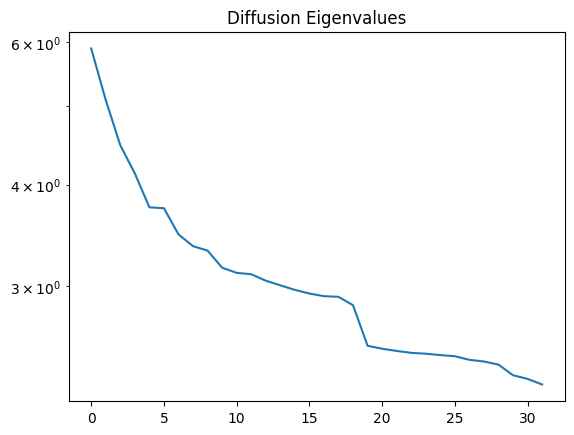

In [8]:
import matplotlib.pyplot as plt
plt.semilogy(S); plt.title("Diffusion Eigenvalues"); plt.show()

In [9]:
time_coord = np.sqrt(1.0 + (X**2).sum(axis=1, keepdims=True))
H = np.hstack([time_coord, X]).astype(np.float32)

ART = pathlib.Path("artifacts"); ART.mkdir(exist_ok=True)
np.save(ART/"item_vecs_h33.npy", H)
print("Hyperboloid vectors saved:", ART/"item_vecs_h33.npy")

Hyperboloid vectors saved: artifacts/item_vecs_h33.npy
